In [ ]:
#| default_exp quaternions
#| default_cls_lvl 3

In [ ]:
#| export
from tsfast.data import *
from tsfast.models import *
from tsfast.learner import *

from fastai.basics import *

## Quaternion Type

In [ ]:
#| export
class TensorQuaternionInclination(TensorSequences): pass
class TensorQuaternionAngle(TensorSequences): pass

In [ ]:
from nbdev.config import get_config

In [ ]:
project_root = get_config().config_file.parent
f_path = project_root / 'test_data/orientation'

In [ ]:
hdf_files = get_hdf_files(f_path)
tfm_src = CreateDict([DfHDFCreateWindows(win_sz=1000,stp_sz=100,clm='acc_x')])
u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z']
# u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z','mag_x','mag_y','mag_z']
y =['opt_a','opt_b','opt_c','opt_d']
dls = DataBlock(blocks=(SequenceBlock.from_hdf(u,TensorSequencesInput),
                        SequenceBlock.from_hdf(y,TensorQuaternionInclination)),
                get_items=tfm_src,
                splitter=RandomSplitter(0.1)
               ).dataloaders(hdf_files,shufflish=True,bs=128)

## Basic Operations

In [ ]:
tq1 = tensor([
    [1,0,0,0],
    [0.5,0.5,0.5,0.5],
    ])
tq2 = tensor([
    [0.5,0.5,0.5,0.5],
    [0.5,0.5,0.5,0.5],
    ])
tq1.shape

torch.Size([2, 4])

In [ ]:
#| export
_pi = torch.Tensor([3.14159265358979323846])
def rad2deg(t):
    return 180. * t / _pi.to(t.device).type(t.dtype)

In [ ]:
test_eq(float(rad2deg(_pi)),180)

In [ ]:
#| export
@torch.jit.script
def multiplyQuat(q1, q2):
    """quat1*quat2"""
    o1 = q1[..., 0] * q2[..., 0] - q1[..., 1] * q2[..., 1] - q1[..., 2] * q2[..., 2] - q1[..., 3] * q2[..., 3]
    o2 = q1[..., 0] * q2[..., 1] + q1[..., 1] * q2[..., 0] + q1[..., 2] * q2[..., 3] - q1[..., 3] * q2[..., 2]
    o3 = q1[..., 0] * q2[..., 2] - q1[..., 1] * q2[..., 3] + q1[..., 2] * q2[..., 0] + q1[..., 3] * q2[..., 1]
    o4 = q1[..., 0] * q2[..., 3] + q1[..., 1] * q2[..., 2] - q1[..., 2] * q2[..., 1] + q1[..., 3] * q2[..., 0]
    return torch.stack([o1,o2,o3,o4],dim=-1)

In [ ]:
# q = tq1.repeat(1000,1)

In [ ]:
# %%timeit
# torch.cumprod(q,dim=-1)

In [ ]:
# %%timeit
# [q*q for _ in range(1000)]

In [ ]:
test_eq(multiplyQuat(tq1,tq2),tensor([[ 0.5000,  0.5000,  0.5000,  0.5000],
                                    [-0.5000,  0.5000,  0.5000,  0.5000]]))

In [ ]:
#| export
def norm_quaternion(q):
    return q / q.norm( p=2,dim=-1)[...,None]

In [ ]:
test_eq(norm_quaternion(tq1*5),tq1)
test_eq(norm_quaternion(tq1/_pi),tq1)
test_eq(norm_quaternion(tq1[None,...]),tq1[None,...])

In [ ]:
#| export
_conjugate_quaternion = tensor([1,-1,-1,-1])

def conjQuat(q):
    return q*_conjugate_quaternion.to(q.device).type(q.dtype)

In [ ]:
test_eq(conjQuat(tq1),tensor([[ 1.0000, -0.0000, -0.0000, -0.0000],
                             [ 0.5000, -0.5000, -0.5000, -0.5000]]))

In [ ]:
#| export
def diffQuat(q1,q2,norm=True):
    if norm:
        nq1 = norm_quaternion(q1)
        nq2 = norm_quaternion(q2)
    else:
        nq1 = q1
        nq2 = q2
        
        
    return relativeQuat(nq1,nq2) #somehow relativeQuat does not work for backpropagation
#     return multiplyQuat(nq1, conjQuat(nq2))


@torch.jit.script
def relativeQuat(q1, q2):
    """quat1*inv(quat2)"""
    
    o1 =  q1[..., 0] * q2[..., 0] + q1[..., 1] * q2[..., 1] + q1[..., 2] * q2[..., 2] + q1[..., 3] * q2[..., 3]
    o2 = -q1[..., 0] * q2[..., 1] + q1[..., 1] * q2[..., 0] - q1[..., 2] * q2[..., 3] + q1[..., 3] * q2[..., 2]
    o3 = -q1[..., 0] * q2[..., 2] + q1[..., 1] * q2[..., 3] + q1[..., 2] * q2[..., 0] - q1[..., 3] * q2[..., 1]
    o4 = -q1[..., 0] * q2[..., 3] - q1[..., 1] * q2[..., 2] + q1[..., 2] * q2[..., 1] + q1[..., 3] * q2[..., 0]
    
    return torch.stack([o1,o2,o3,o4],dim=-1)

In [ ]:
test_eq(diffQuat(tq1,tq2),diffQuat(tq1,tq2*5))
test_ne(diffQuat(tq1,tq2),diffQuat(tq1,tq2*5,norm=False))
test_ne(diffQuat(tq1,tq2),diffQuat(tq1[None,...],tq2[None,...]))

In [ ]:
#| export
def safe_acos(t,eps = 4e-8):
    '''numericaly stable variant of arcuscosine'''
#     eps = 4e-8 #minimum value for acos(1) != 0
    return t.clamp(-1.0 + eps, 1.0 - eps).acos()

In [ ]:
test_ne(safe_acos(tensor(1.))*1e6,0)
test_eq(safe_acos(tensor(-0.)),_pi/2)

In [ ]:
#| export
def safe_acos_double(t,eps = 1e-16):
    '''numericaly stable variant of arcuscosine, uses 64bit floats for internal computation for increased accuracy and gradient propagation'''
    return t.type(torch.float64).clamp(-1.0 + eps, 1.0 - eps).acos().type(t.dtype)

In [ ]:
test_ne(safe_acos_double(tensor(1.))*1e6,0)
test_eq(safe_acos_double(tensor(-0.)),_pi/2)

In [ ]:
#| export
def inclinationAngle(q1,q2):
    
    q = diffQuat(q1,q2)
    return 2*safe_acos_double((q[..., 3]**2 + q[..., 0]**2).sqrt())

def relativeAngle(q1,q2):
    q = diffQuat(q1,q2)
    return 2*safe_acos_double((q[..., 0]).abs())

In [ ]:
print('inclination:', rad2deg(inclinationAngle(tq1,tq2)))
print('relative:', rad2deg(relativeAngle(tq1,tq2)))

inclination: tensor([9.0000e+01, 1.7075e-06])
relative: tensor([1.2000e+02, 1.7075e-06])


In [ ]:
#| export
def rollAngle(q1,q2):
    q = diffQuat(q1,q2)
    w,x,y,z= q[...,0],q[...,1],q[...,2],q[...,3]
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    return torch.atan2(t0, t1)

def pitchAngle(q1,q2):
    q = diffQuat(q1,q2)
    w,x,y,z= q[...,0],q[...,1],q[...,2],q[...,3]
    t2 = +2.0 * (w * y - z * x)
    t2 = t2.clamp(-1.0, 1.0 )
    return torch.asin(t2)

In [ ]:
print('roll:', rad2deg(rollAngle(tq1,tq2)))
print('pitch:', rad2deg(pitchAngle(tq1,tq2)))

roll: tensor([0., 0.])
pitch: tensor([-90.,   0.])


In [ ]:
#| export
_unit_quaternion = tensor([1.,0,0,0])
def inclinationAngleAbs(q):
    q = diffQuat(q,_unit_quaternion[None,:])
    return 2*((q[..., 3]**2 + q[..., 0]**2).sqrt()).acos()

In [ ]:
rad2deg(inclinationAngleAbs(tq1))

tensor([ 0., 90.])

In [ ]:
#| export
def rand_quat():
    q = torch.rand((4))*2-1
    q /= q.norm()
    return q

In [ ]:
#| export
def rot_vec(v,q):
    v = F.pad(v, (1,0), "constant", 0)
    return multiplyQuat(conjQuat(q),multiplyQuat(v,q))[...,1:]
#     return multiplyQuat(q,multiplyQuat(v,conjQuat(q)))[...,1:]

In [ ]:
g = tensor([[9.81,0,0]]*5)

In [ ]:
r_quat = rand_quat()
rot_vec(g,r_quat)

tensor([[-1.3618, -4.4243, -8.6491],
        [-1.3618, -4.4243, -8.6491],
        [-1.3618, -4.4243, -8.6491],
        [-1.3618, -4.4243, -8.6491],
        [-1.3618, -4.4243, -8.6491]])

In [ ]:
#| export
def quatFromAngleAxis(angle, axis):
    if len(axis.shape) == 2:
        N = max(angle.shape[0], axis.shape[0])
        assert angle.shape in ((1,), (N,))
        assert axis.shape == (N, 3) or axis.shape == (1, 3)
    else:
        N = angle.shape[0]
        assert angle.shape == (N,)
        assert axis.shape == (3,)
        axis = axis[None, :]

    axis = axis/torch.norm(axis, dim=1)[:, None]
    quat = torch.cat([torch.cos(angle/2)[:,None],axis*torch.sin(angle/2)[:, None]],dim=-1)
    return quat

In [ ]:
#| export
def quatInterp(quat, ind, extend=False):
    """
    Interpolates an array of quaternions of (non-integer) indices using Slerp. Sampling indices are in the range
    0..N-1, for values outside of this range, depending on "extend", the first/last element or NaN is returned.

    See also csg_bigdata.dp.utils.vecInterp.

    :param quat: array of input quaternions (N(xB)x4)
    :param ind: vector containing the sampling indices, shape (M,)
    :param extend: if true, the input data is virtually extended by the first/last value
    :return: interpolated quaternions (Mx4)
    """
    N = quat.shape[0]
    M = ind.shape[0]
    assert quat.shape[-1] == 4
    assert ind.shape == (M,)

    ind = ind.to(quat.device)
    ind0 = torch.clamp(torch.floor(ind).type(torch.long), 0, N-1)
    ind1 = torch.clamp(torch.ceil(ind).type(torch.long), 0, N-1)

    q0 = quat[ind0].type(torch.float64)
    q1 = quat[ind1].type(torch.float64)
    q_1_0 = diffQuat(q0, q1)

    # normalize the quaternion for positive w component to ensure
    # that the angle will be [0, 180°]
    invert_sign_ind = q_1_0[..., 0] < 0
    q_1_0[invert_sign_ind] = -q_1_0[invert_sign_ind]

#     angle = 2 * torch.acos(torch.clamp(q_1_0[:, 0], -1, 1))
    angle = 2*safe_acos_double((q_1_0[..., 0]))#.type_as(quat)
    axis = q_1_0[..., 1:]

    # copy over (almost) direct hits
#     with np.errstate(invalid='ignore'):
    direct_ind = angle < 1e-06
    quat_out = torch.empty_like(q0)
    # print(quat_out.shape, direct_ind.shape, q0.shape)
    quat_out[direct_ind] = q0[direct_ind]

    interp_ind = ~direct_ind
    t01 = ind - ind0
    if len(quat.shape) == 3: t01 = t01[:,None] #extend shape if batches are part of the tensor
    q_t_0 = quatFromAngleAxis((t01*angle)[interp_ind], axis[interp_ind])
    quat_out[interp_ind] = multiplyQuat(q0[interp_ind], q_t_0)

    if not extend:
        quat_out[ind < 0] = np.nan
        quat_out[ind > N - 1] = np.nan
#     import pdb;pdb.set_trace()

    
    return quat_out.type_as(quat)

In [ ]:
1e-3/_pi*180

tensor([0.0573])

In [ ]:
q = torch.rand((1000000,1,4))*2-1
q /= q.norm()
x = torch.linspace(0,q.shape[0]-1,150001)
q_i = quatInterp(q,x)
torch.isnan(inclinationAngleAbs(q_i)).sum()

tensor(0)

In [ ]:
q_i = quatInterp(q,x)

[<matplotlib.lines.Line2D>]

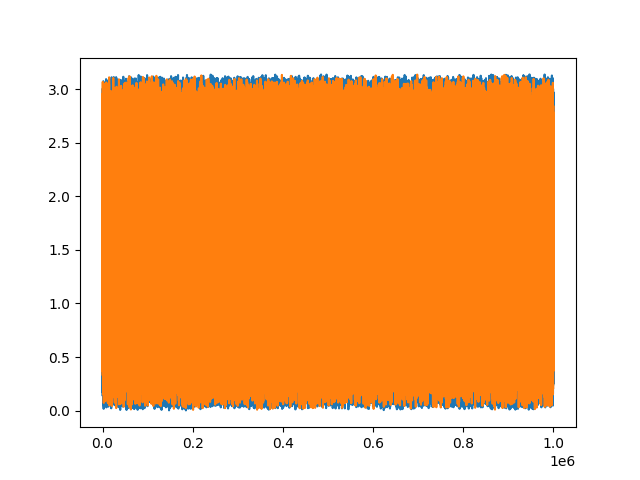

In [ ]:
plt.figure()
plt.plot(inclinationAngleAbs(q))
plt.plot(x,inclinationAngleAbs(q_i))

## Loss Functions

In [ ]:
#| export
def inclination_loss(q1,q2):
    q = diffQuat(q1,q2)
    q_abs = (q[..., 3]**2 + q[..., 0]**2).sqrt()-1
    return (q_abs**2).mean().sqrt()

In [ ]:
inclination_loss(tq1,tq2)

tensor(0.2071)

In [ ]:
#| export
def inclination_loss_abs(q1,q2):
    q = diffQuat(q1,q2)
    q_abs = (q[..., 3]**2 + q[..., 0]**2).sqrt()-1
    return q_abs.abs().mean()

In [ ]:
inclination_loss_abs(tq1,tq2)

tensor(0.1464)

In [ ]:
#| export
def inclination_loss_squared(q1,q2):
    q = diffQuat(q1,q2)
    q_abs = (q[..., 3]**2 + q[..., 0]**2).sqrt()-1
    return (q_abs**2).mean()

In [ ]:
# %%timeit
inclination_loss_squared(tq1,tq2)

tensor(0.0429)

In [ ]:
#| export
def inclination_loss_smooth(q1,q2):
    q = diffQuat(q1,q2)
    q_abs = (q[..., 3]**2 + q[..., 0]**2).sqrt()-1
    return F.smooth_l1_loss(q_abs,torch.zeros_like(q_abs))

In [ ]:
# %%timeit
inclination_loss_smooth(tq1,tq2)

tensor(0.0214)

In [ ]:
#| export
def abs_inclination(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return  inclination.abs().mean()

In [ ]:
abs_inclination(tq1,tq2)

tensor(0.7854)

In [ ]:
#| export
def ms_inclination(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return  (inclination**2).mean()

In [ ]:
ms_inclination(tq1,tq2)

tensor(1.2337)

In [ ]:
#| export
def rms_inclination(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return (inclination**2).mean().sqrt()

In [ ]:
rms_inclination(tq1,tq2)

tensor(1.1107)

In [ ]:
#| export
def smooth_inclination(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return F.smooth_l1_loss(inclination,torch.zeros_like(inclination))

In [ ]:
smooth_inclination(tq1,tq2)

tensor(0.5354)

In [ ]:
#| export
def rms_inclination_deg(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return  rad2deg((inclination**2).mean().sqrt())

In [ ]:
rms_inclination_deg(tq1,tq2)

tensor([63.6396])

In [ ]:
#| export
def rms_pitch_deg(q1,q2):
    inclination = pitchAngle(q1,q2)
    return  rad2deg((inclination**2).mean().sqrt())

In [ ]:
rms_pitch_deg(tq1,tq2)

tensor([63.6396])

In [ ]:
#| export
def rms_roll_deg(q1,q2):
    inclination = rollAngle(q1,q2)
    return  rad2deg((inclination**2).mean().sqrt())

In [ ]:
rms_roll_deg(tq1,tq2)

tensor([0.])

In [ ]:
#| export
def mean_inclination_deg(q1,q2):
    inclination = inclinationAngle(q1,q2)
    return  rad2deg(inclination.mean())

In [ ]:
mean_inclination_deg(tq1,tq2)

tensor([45.])

In [ ]:
#| export
def angle_loss(q1,q2):
    q = diffQuat(q1,q2)
    return (q[..., 0]-1).abs().mean()

In [ ]:
#| export
def angle_loss_opt(q1,q2):
    q1 = norm_quaternion(q1)
    q2 = norm_quaternion(q2)
    
    q2 = conjQuat(q2)
    q = q1[..., 0] * q2[..., 0] - q1[..., 1] * q2[..., 1] - q1[..., 2] * q2[..., 2] - q1[..., 3] * q2[..., 3]
    return (q-1).abs().mean()

In [ ]:
#| export
def ms_rel_angle(q1,q2):
    rel_angle = relativeAngle(q1,q2)
    return  (rel_angle**2).mean()

In [ ]:
ms_rel_angle(tq1,tq2)

tensor(2.1932)

In [ ]:
#| export
def abs_rel_angle(q1,q2):
    rel_angle = relativeAngle(q1,q2)
    return  rel_angle.abs().mean()

In [ ]:
#| export
def rms_rel_angle_deg(q1,q2):
    rel_angle = relativeAngle(q1,q2)
    return  rad2deg((rel_angle**2).mean().sqrt())

In [ ]:
rms_rel_angle_deg(tq1,tq2)

tensor([84.8528])

In [ ]:
#| export
def mean_rel_angle_deg(q1,q2):
    rel_angle = relativeAngle(q1,q2)
    return  rad2deg(rel_angle.mean())

In [ ]:
mean_rel_angle_deg(tq1,tq2)

tensor([60.])

In [ ]:
#| export
def deg_rmse(inp, targ):
    return rad2deg(fun_rmse(inp, targ))

## Callbacks

In order to assure that the output of the model are close to unit quaternions the distance will be added to the loss

In [ ]:
#| export
from fastai.callback.hook import *
@delegates()
class QuaternionRegularizer(HookCallback):
    "Callback that adds AR and TAR to the loss, calculated by output of provided layer"
    run_before=TrainEvalCallback
    def __init__(self,reg_unit=0.0,detach=False, **kwargs):
        super().__init__(detach=detach,**kwargs)
        store_attr('reg_unit')
        
    def hook(self, m, i, o): 
        if type(o) is torch.Tensor:
            self.out = o
        else:
            self.out = o[0]
    
    def after_loss(self):
        if not self.training: return
        h = self.out.float()
        
        if self.reg_unit != 0.:  
            l_a = float(self.reg_unit) * ((1-h.norm(dim=-1))**2).mean()
#             import pdb; pdb.set_trace()
            self.learn.loss_grad += l_a 

In [ ]:
#| export
def augmentation_groups(u_groups):
    '''returns the rotation list corresponding to the input groups'''
    u_groups = np.cumsum([0] + u_groups)
    return [[u_groups[i],u_groups[i+1]-1] for i in range(len(u_groups)-1)]

In [ ]:
u_raw_groups = [3,3]
test_eq(augmentation_groups(u_raw_groups),[[0,2],[3,5]])

In [ ]:
#| export
class QuaternionAugmentation(Transform):
    "A transform that before_call its state at each `__call__`"
    split_idx = 0
    def __init__(self,inp_groups, **kwargs):
        super().__init__(**kwargs)
        self.inp_groups = inp_groups
        self.r_quat = None
        for g in inp_groups: 
            l = g[1]-g[0]+1
            if l != 4 and l != 3: raise AttributeError

    def __call__(self, b, split_idx=None, **kwargs):
        #import pdb; pdb.set_trace()
        self.r_quat = rand_quat()
        return super().__call__(b, split_idx=split_idx, **kwargs) 

    def encodes(self, x:(TensorSequences)):
        #import pdb; pdb.set_trace()
        for g in self.inp_groups:
            tmp = x[...,g[0]:g[1]+1]
            if tmp.shape[-1] == 3:
                x[...,g[0]:g[1]+1] = rot_vec(tmp,self.r_quat)
            else:
                x[...,g[0]:g[1]+1] = multiplyQuat(tmp,self.r_quat)
        return x
    
    def encodes(self, x:(TensorQuaternionInclination,TensorQuaternionAngle)):
        return multiplyQuat(x,self.r_quat)

In [ ]:
n_skip = 2**8


inp,out = get_inp_out_size(dls)
# model = SimpleGRU(inp,out,num_layers=1,hidden_size=100)
model = TCN(inp,out,hl_depth=8,hl_width=10)

skip = partial(SkipNLoss,n_skip=n_skip)
metrics=rms_inclination_deg
cbs = [QuaternionRegularizer(reg_unit=1,modules=[model])]

lrn = Learner(dls,model,loss_func=ms_inclination,opt_func=ranger,metrics=metrics)

/home/pheenix/miniconda3/envs/env_tsfast/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
lrn.fit_one_cycle(1,lr_max=3e-3)

epoch,train_loss,valid_loss,rms_inclination_deg,time
0,3.321246,3.187154,102.287865,00:02


## Resampling Model

In [ ]:
#| export
from scipy.signal import resample
class Quaternion_ResamplingModel(nn.Module):
    '''
        Module that resamples the signal before and after the prediction of its model.
        Usefull for using models on datasets with different samplingrates.
        
        sampling_method: method used for resampling ['resample','interpolate']
    '''
    
    def __init__(self,model,fs_targ,fs_mean=0,fs_std=1,quaternion_sampling=True):
        super().__init__()
        self.model =model
        self.fs_targ =fs_targ
        self.register_buffer('fs_mean',tensor(fs_mean))
        self.register_buffer('fs_std',tensor(fs_std))
        self.quaternion_sampling = quaternion_sampling

    def forward(self, x):
        dt = (x[0,0,-1]*self.fs_std)+self.fs_mean
        fs_src = 1/dt
        x_len = x.shape[1]
        res_len = int(x.shape[1]*self.fs_targ/(fs_src+10))
        x_raw = x[...,:-1]
        if x_len == res_len:
            res = self.model(x_raw)
        else:
#             x_new = nn.functional.interpolate(x_raw.transpose(1,2), size=res_len, mode='linear',align_corners=False).transpose(1,2)
#             import pdb;pdb.set_trace()
            x_new = tensor(resample(x_raw.detach().cpu().numpy(),res_len,axis =1)).to(x_raw.device) 
            res = self.model(x_new)
            if self.quaternion_sampling: 
                res = quatInterp(res.transpose(0,1),torch.linspace(0,res.shape[1]-1,x_len)).transpose(0,1)
            else:
                res = nn.functional.interpolate(res.transpose(1,2), size=x_len, mode='linear',align_corners=False).transpose(1,2)
        
        return res

In [ ]:
# dls = DataBlock(blocks=(SequenceBlock.from_hdf(u + ['dt'],TensorSequencesInput),
#                         SequenceBlock.from_hdf(y,TensorQuaternionInclination)),
#                 get_items=tfm_src,
#                 splitter=ApplyToDict(FuncSplitter(lambda o: 'experiment2' in str(o)))
#                ).dataloaders(hdf_files,shufflish=True,bs=128)
# model = TCN(inp,out,hl_depth=8,hl_width=10)
# Learner(dls,Quaternion_ResamplingModel(model,10,quaternion_sampling=False),loss_func=ms_inclination).fit(1)

## Quaternion Datablock

In [ ]:
#| exporti
def relativeQuat_np(q1, q2):
    """inv(quat1)*quat2"""
    if isinstance(q1, np.ndarray) and q1.shape == (4,):
        q1 = q1[np.newaxis]  # convert to 1x4 matrix
        shape = q2.shape
    elif isinstance(q1, np.ndarray) and q1.shape == (1, 4):
        shape = q2.shape
    elif isinstance(q2, np.ndarray) and q2.shape == (4,):
        q2 = q2[np.newaxis]  # convert to 1x4 matrix
        shape = q1.shape
    elif isinstance(q2, np.ndarray) and q2.shape == (1, 4):
        shape = q1.shape
    else:
        assert q1.shape == q2.shape
        shape = q1.shape
    output = np.zeros(shape=shape)
    output[:, 0] = q1[:, 0] * q2[:, 0] + q1[:, 1] * q2[:, 1] + q1[:, 2] * q2[:, 2] + q1[:, 3] * q2[:, 3]
    output[:, 1] = q1[:, 0] * q2[:, 1] - q1[:, 1] * q2[:, 0] - q1[:, 2] * q2[:, 3] + q1[:, 3] * q2[:, 2]
    output[:, 2] = q1[:, 0] * q2[:, 2] + q1[:, 1] * q2[:, 3] - q1[:, 2] * q2[:, 0] - q1[:, 3] * q2[:, 1]
    output[:, 3] = q1[:, 0] * q2[:, 3] - q1[:, 1] * q2[:, 2] + q1[:, 2] * q2[:, 1] - q1[:, 3] * q2[:, 0]
    return output
def quatFromAngleAxis_np(angle, axis):
    """
        Get quaternion from angle and axis.

        If angle is 0, the output will be an identity quaternion.
        If axis is zero vector, a ValueError will be raised unless corresponding angle is 0.
        If  Nx3 axis or N angle are given, the output will be row-wise broadcasted into Nx4:

        >>> q = csgimu.quatFromAngleAxis([0, 1, 2], [1, 0, 0])
        >>> q
        array([[1.        , 0.        , 0.        , 0.        ],
               [0.87758256, 0.47942554, 0.        , 0.        ],
               [0.54030231, 0.84147098, 0.        , 0.        ]])

        :param angle: scalar or N angle in rad input
        :param axis: Nx3 or 1x3 vector input array
        :param debug: enables debug output
        :param plot: enables debug plot
        :return:
            - output: Nx4 or 1x4 quaternion output array
            - debug: dict with debug values (only if debug==True)

        """

    angle = np.asarray(angle, np.float64)
    axis = np.asarray(axis, np.float64)

    is1D = (angle.shape == tuple() or angle.shape == (1,)) and axis.shape == (3,)

    if angle.shape == tuple():
        angle = angle.reshape(1)  # equivalent to np.atleast_1d
    if axis.shape == (3,):
        axis = axis.reshape((1, 3))

    N = max(angle.shape[0], axis.shape[0])

    # for (1x1) case
    if angle.shape == (1, 1):
        angle = angle.ravel()

    assert angle.shape == (N,) or angle.shape == (1,), f'invalid angle shape: {angle.shape}'
    assert axis.shape == (N, 3) or axis.shape == (1, 3), f'invalid axis shape: {axis.shape}'

    angle_brodcasted = np.broadcast_to(angle, (N,))
    axis_brodcasted = np.broadcast_to(axis, (N, 3))

    norm = np.linalg.norm(axis_brodcasted, axis=1)

    identity = norm < np.finfo(np.float64).eps

    q = np.zeros((N, 4), np.float64)
    q[identity] = np.array([1, 0, 0, 0])
    q[~identity] = np.concatenate((np.cos(angle_brodcasted[~identity][:, np.newaxis] / 2), axis_brodcasted[~identity]
                                 * np.array(np.sin(angle_brodcasted[~identity] / 2.0) / norm[~identity])[:, np.newaxis]),
                                axis=1)

    if is1D:
        q = q.reshape((4,))

    return q

def multiplyQuat_np(q1, q2):
    """quat1*quat2"""
    if isinstance(q1, np.ndarray) and q1.shape == (4,):
        q1 = q1[np.newaxis]  # convert to 1x4 matrix
        shape = q2.shape
    elif isinstance(q1, np.ndarray) and q1.shape == (1, 4):
        shape = q2.shape
    elif isinstance(q2, np.ndarray) and q2.shape == (4,):
        q2 = q2[np.newaxis]  # convert to 1x4 matrix
        shape = q1.shape
    elif isinstance(q2, np.ndarray) and q2.shape == (1, 4):
        shape = q1.shape
    else:
        assert q1.shape == q2.shape
        shape = q1.shape
    output = np.zeros(shape=shape)
    output[:, 0] = q1[:, 0] * q2[:, 0] - q1[:, 1] * q2[:, 1] - q1[:, 2] * q2[:, 2] - q1[:, 3] * q2[:, 3]
    output[:, 1] = q1[:, 0] * q2[:, 1] + q1[:, 1] * q2[:, 0] + q1[:, 2] * q2[:, 3] - q1[:, 3] * q2[:, 2]
    output[:, 2] = q1[:, 0] * q2[:, 2] - q1[:, 1] * q2[:, 3] + q1[:, 2] * q2[:, 0] + q1[:, 3] * q2[:, 1]
    output[:, 3] = q1[:, 0] * q2[:, 3] + q1[:, 1] * q2[:, 2] - q1[:, 2] * q2[:, 1] + q1[:, 3] * q2[:, 0]
    return output


def quatInterp_np(quat, ind, extend=True):
    """
    Interpolates an array of quaternions (Nx4) of (non-integer) indices using Slerp. Sampling indices are in the range
    0..N-1. For values outside of this range, depending on "extend", the first/last element or NaN is returned.
    If the input consists 2 quaternions and ind =[0.5], the result should be (1,4) and be the 50/50 interpolation
    between the two input quaternions.

    >>> a=csgimu.quatInterp(np.array([[1,0,0,0],[0,0,1,0]]), np.array([0.5]), extend=True,debug=False,plot=False)
    >>> a
        array([[0, 0, 0, 0]])

    :param quat: array of input quaternions (Nx4)
    :param ind: vector containing the sampling indices for desired output, shape (M,)
    :param extend: if true, the input data is virtually extended by the first/last value
    :return: interpolated quaternions (Mx4)
    """
    ind = np.atleast_1d(ind)
    N = quat.shape[0]
    M = ind.shape[0]
    assert quat.shape == (N, 4)
    assert ind.shape == (M,)

    ind0 = np.clip(np.floor(ind).astype(int), 0, N-1)
    ind1 = np.clip(np.ceil(ind).astype(int), 0, N-1)

    q0 = quat[ind0]
    q1 = quat[ind1]
    q_1_0 = relativeQuat_np(q0, q1)

    # normalize the quaternion for positive w component to ensure
    # that the angle will be [0, 180°]
    invert_sign_ind = q_1_0[:, 0] < 0
    q_1_0[invert_sign_ind] = -q_1_0[invert_sign_ind]

    angle = 2 * np.arccos(np.clip(q_1_0[:, 0], -1, 1))
    axis = q_1_0[:, 1:]

    # copy over (almost) direct hits
    with np.errstate(invalid='ignore'):
        direct_ind = angle < 1e-06
    quat_out = np.empty_like(q0)
    # print(quat_out.shape, direct_ind.shape, q0.shape)
    quat_out[direct_ind] = q0[direct_ind]

    interp_ind = ~direct_ind
    t01 = ind - ind0
    q_t_0 = quatFromAngleAxis_np((t01*angle)[interp_ind], axis[interp_ind])
    quat_out[interp_ind] = multiplyQuat_np(q0[interp_ind], q_t_0)

    if not extend:
        quat_out[ind < 0] = np.nan
        quat_out[ind > N - 1] = np.nan

    quat_out_norm = np.linalg.norm(quat_out, axis=1)

    return quat_out

In [ ]:
#| export
import h5py


class HDF2Quaternion(HDF2Sequence):

    def _hdf_extract_sequence(self,hdf_path,dataset = None, l_slc = None, r_slc= None, resampling_factor=None, fs_idx =None,dt_idx =False,fast_resample=True):
        '''
        extracts a sequence with the shape [seq_len x num_features]

        hdf_path: file path of hdf file, may be a string or path type
        clms: list of dataset names of sequences in hdf file
        dataset: dataset root for clms. Useful for multiples sequences stored in one file.
        l_slc: left boundary for extraction of a window of the whole sequence
        r_slc: right boundary for extraction of a window of the whole sequence
        resampling_factor: scaling factor for the sequence length, uses 'resample_interp' for resampling
        fs_idx: clms list idx of fs entry in sequence. Will be scaled by resampling_factor after resampling
        dt_idx: clms list idx of dt entry in sequence. Will be scaled by resampling_factor after resampling
        '''

        if resampling_factor is not None:
            seq_len = r_slc-l_slc if l_slc is not None and r_slc is not None else None #calculate seq_len for later slicing, necesary because of rounding errors in resampling
            if l_slc is not None: l_slc= math.floor(l_slc/resampling_factor)
            if r_slc is not None: r_slc= math.ceil(r_slc/resampling_factor)

        with h5py.File(hdf_path,'r') as f:
            ds = f if dataset is None else f[dataset]
            l_array = [(ds[n][l_slc:r_slc]) for n in self.clm_names]
            seq = np.stack(l_array,axis=-1)

        if resampling_factor is not None:
#             res_seq = resample_interp(seq,resampling_factor)
            res_seq = quatInterp_np(seq,np.linspace(0,seq.shape[0]-1,int(seq.shape[0]*resampling_factor)))
            if fs_idx is not None: res_seq[:,fs_idx] = seq[0,fs_idx] * resampling_factor
            if dt_idx is not None: res_seq[:,dt_idx] = seq[0,dt_idx] / resampling_factor
            seq = res_seq

            if seq_len is not None: seq = seq[:seq_len] #cut the part of the sequence that is too long because of resampling rounding errors

        return seq

In [ ]:
#| export
class QuaternionBlock(TransformBlock):
    def __init__(self, seq_extract,padding=False):
        return super().__init__(type_tfms=[seq_extract],
                                batch_tfms=[Normalize(axes=[0,1])],
                                dls_kwargs={} if not padding else {'before_batch': pad_sequence})

    @classmethod
    @delegates(HDF2Quaternion, keep=True)
    def from_hdf(cls, clm_names, seq_cls=TensorQuaternionInclination,padding=False, **kwargs):
        return cls(HDF2Quaternion(clm_names,to_cls=seq_cls,**kwargs), padding)

In [ ]:
tfm_src = CreateDict([DfResamplingFactor(2000/7,np.linspace(50,500,10)),DfHDFCreateWindows(win_sz=1000,stp_sz=100,clm='acc_x')])
dls = DataBlock(blocks=(SequenceBlock.from_hdf(u,TensorSequencesInput),
                        QuaternionBlock.from_hdf(y)),
                get_items=tfm_src,
                splitter=RandomSplitter(0.5)
               ).dataloaders(hdf_files,bs=2)

In [ ]:
#test_eq(len(dls.items),83877) 

## Inclination Datablock

In [ ]:
#| export
class TensorInclination(TensorSequences): pass

In [ ]:
#| export
import h5py
class HDF2Inclination(HDF2Sequence):
        
    def _hdf_extract_sequence(self,hdf_path,dataset = None, l_slc = None, r_slc= None,down_s=None):
        with h5py.File(hdf_path,'r') as f:
            ds = f if dataset is None else f[dataset]
            l_array = [ds[n][l_slc:r_slc] for n in self.clm_names]
            seq = np.vstack(l_array).T
            seq = array(inclinationAngleAbs(tensor(seq))[:,None])
            return seq

In [ ]:
#| export
class InclinationBlock(TransformBlock):
    def __init__(self, seq_extract,padding=False):
        return super().__init__(type_tfms=[seq_extract],
                                batch_tfms=[Normalize(axes=[0,1])],
                                dls_kwargs={} if not padding else {'before_batch': pad_sequence})

    @classmethod
    @delegates(HDF2Inclination, keep=True)
    def from_hdf(cls, clm_names, seq_cls=TensorInclination,padding=False, **kwargs):
        return cls(HDF2Inclination(clm_names,to_cls=seq_cls,**kwargs), padding)

In [ ]:
# f_paths = '/mnt/Data/Systemidentification/Orientation_Estimation/'
# hdf_files = get_hdf_files(f_paths)
# tfm_src = CreateDict([DfHDFCreateWindows(win_sz=1000,stp_sz=100,clm='acc_x')])
# u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z']
# # u = ['acc_x','acc_y','acc_z','gyr_x','gyr_y','gyr_z','mag_x','mag_y','mag_z']
# y =['opt_a','opt_b','opt_c','opt_d']
# dls = DataBlock(blocks=(SequenceBlock.from_hdf(u),
#                         InclinationBlock.from_hdf(y)),
#                 get_items=tfm_src,
#                 splitter=ApplyToDict(FuncSplitter(lambda o: 'experiment2' in str(o)))
#                ).dataloaders(hdf_files,shufflish=True,bs=128)

## Show Results

In [ ]:
#| export
def plot_scalar_inclination(axs,in_sig,targ_sig,out_sig=None, **kwargs):
#     import pdb; pdb.set_trace()
    first_targ = targ_sig[0].repeat(targ_sig.shape[0],1)
    axs[0].plot(rad2deg(targ_sig).detach().numpy())
    axs[0].label_outer()
    axs[0].set_ylabel('inclination[°]')
    
    if out_sig is not None:
        axs[0].plot(rad2deg(out_sig).detach().numpy())
        axs[0].legend(['y','ŷ'])
        axs[1].plot(rad2deg(targ_sig-out_sig).detach().numpy())
        axs[1].label_outer()
        axs[1].set_ylabel('error[°]')
        
    axs[-1].plot(in_sig)

In [ ]:
#| export
def plot_quaternion_inclination(axs,in_sig,targ_sig,out_sig=None, **kwargs):
#     import pdb; pdb.set_trace()
    axs[0].plot(rad2deg(inclinationAngleAbs(targ_sig)).detach().numpy())
    axs[0].label_outer()
    axs[0].legend(['y'])
    axs[0].set_ylabel('inclination[°]')
    
    if out_sig is not None:
        axs[0].plot(rad2deg(inclinationAngleAbs(out_sig)).detach().numpy())
        axs[0].legend(['y','ŷ'])
        axs[1].plot(rad2deg(inclinationAngle(out_sig,targ_sig)).detach().numpy())
        axs[1].label_outer()
        axs[1].set_ylabel('error[°]')
        if 'ref' in kwargs:
#             axs[0].plot(rad2deg(inclinationAngleAbs(kwargs['ref'])))
#             axs[0].legend(['y','ŷ','y_ref'])
            axs[1].plot(rad2deg(inclinationAngle(targ_sig,kwargs['ref'])).detach().numpy())
            axs[1].legend(['ŷ','y_ref'])
        
    axs[-1].plot(in_sig)

In [ ]:
#| export
def plot_quaternion_rel_angle(axs,in_sig,targ_sig,out_sig=None, **kwargs):
#     import pdb; pdb.set_trace()
    first_targ = targ_sig[0].repeat(targ_sig.shape[0],1)
    axs[0].plot(rad2deg(relativeAngle(first_targ,targ_sig)).detach().numpy())
    axs[0].label_outer()
    axs[0].legend(['y'])
    axs[0].set_ylabel('angle[°]')
    
    if out_sig is not None:
        axs[0].plot(rad2deg(relativeAngle(first_targ,out_sig)).detach().numpy())
        axs[0].legend(['y','ŷ'])
        axs[1].plot(rad2deg(relativeAngle(out_sig,targ_sig)).detach().numpy())
        axs[1].label_outer()
        axs[1].set_ylabel('error[°]')
        
    axs[-1].plot(in_sig)

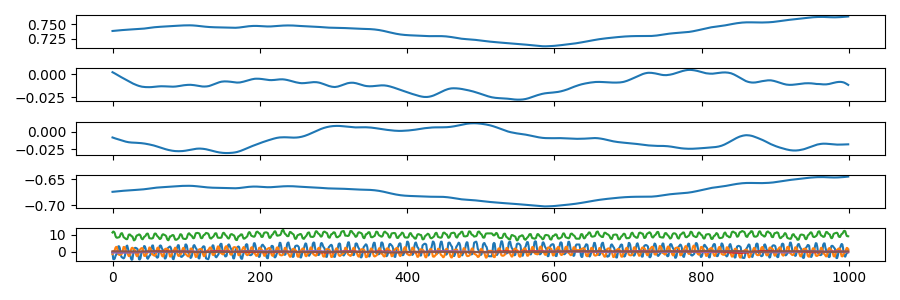

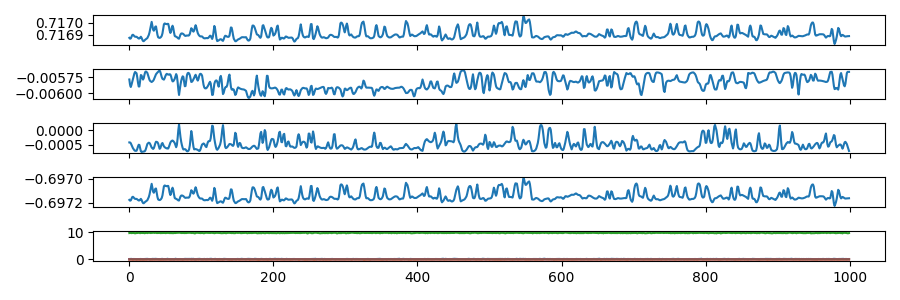

In [ ]:
dls.show_batch(max_n=3,ds_idx=0)

In [ ]:
#| export
@typedispatch
def show_results(x:TensorSequences, y:TensorInclination, samples, outs, ctxs=None, max_n=2, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 2
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_scalar_inclination,outs, **kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_scalar_inclination,outs, **kwargs)
    return ctxs

In [ ]:
#| export
@typedispatch
def show_batch(x:TensorSequences, y:TensorInclination, samples, ctxs=None, max_n=6, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 1
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_scalar_inclination, **kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_scalar_inclination, **kwargs)
    return ctxs

In [ ]:
#| export
@typedispatch
def show_results(x:TensorSequences, y:TensorQuaternionInclination, samples, outs, ctxs=None, max_n=2, **kwargs):
    if 'quat' in kwargs: return show_results(x,TensorSequencesOutput(y), samples,outs, ctxs, max_n , **kwargs)
    n_samples = min(len(samples), max_n)
    n_targ = 2
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_quaternion_inclination,outs,**kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_quaternion_inclination,outs,**kwargs)
    return ctxs

In [ ]:
#| export
@typedispatch
def show_batch(x:TensorSequences, y:TensorQuaternionInclination, samples, ctxs=None, max_n=6, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 1
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_quaternion_inclination)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_quaternion_inclination)
    return ctxs

In [ ]:
#| export
@typedispatch
def show_results(x:TensorSequences, y:TensorQuaternionAngle, samples, outs, ctxs=None, max_n=2, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 2
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_quaternion_rel_angle,outs, **kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_quaternion_rel_angle,outs, **kwargs)
    return ctxs

In [ ]:
#| export
@typedispatch
def show_batch(x:TensorSequences, y:TensorQuaternionAngle, samples, ctxs=None, max_n=6, **kwargs):
    n_samples = min(len(samples), max_n)
    n_targ = 1
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,n_targ,samples,plot_quaternion_rel_angle, **kwargs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,n_targ,samples,plot_quaternion_rel_angle, **kwargs)
    return ctxs

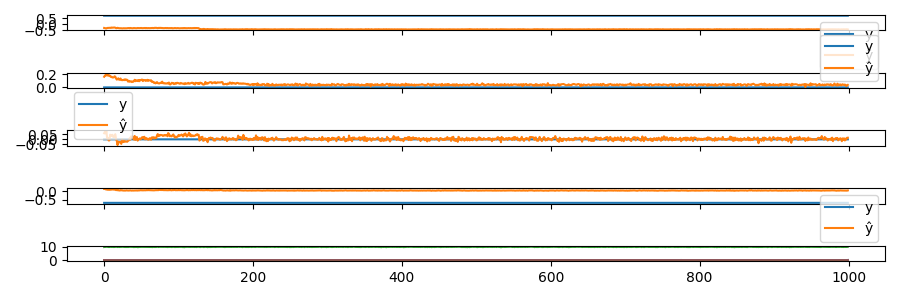

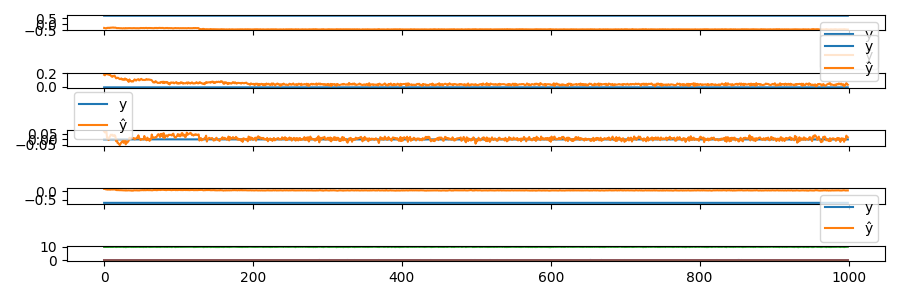

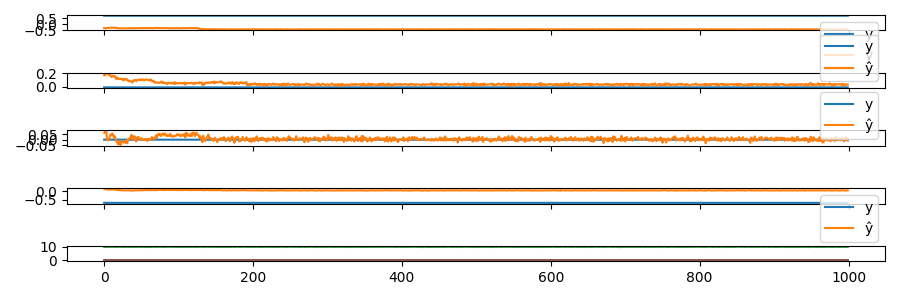

In [ ]:
lrn.show_results(max_n=3,ds_idx=0,shuffle=True,quat=True)

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()